[<img src="photutils_banner.svg" width=300 alt="">](http://photutils.readthedocs.io/en/stable/index.html)

# Background Estimation with `photutils`
---

##### What is background estimation?
In order to most accurately do photometric analysis of celestial sources in image data, it is important to estimate and subtract the image background. Any astronomical image will have background noise, due to both detector effects and background emission from the night sky. This noise can be modeled as uniform, or as varying with position on the detector. 

The `photutils` package provides tools for estimating 2-dimensional background noise, which can then be subtracted from an image to ensure the most accurate photometry possible.

##### What does this tutorial include?
This tutorial covers the basics of background estimation and subtraction, including the following methods:
- Scalar Background Estimation
- 2-D Background Estimation

The methods demonstrated here are available in narrative form within the `photutils.background` [documentation](http://photutils.readthedocs.io/en/stable/background.html).

<div class="alert alert-block alert-info">**Note:** This notebook focuses on global background estimation. Local background subtraction with <b>annulus apertures</b> is demonstrated in the [aperture photometry notebook](03_photutils_aperture_photometry.ipynb).</div>

<div class="alert alert-block alert-warning">**Important:** Before proceeding, please be sure to update your versions of `astropy`, `matplotlib`, and `photutils`, or this notebook may not work properly. Or, if you don't want to handle packages individually, you can always use (and keep updated!) the [AstroConda](https://astroconda.readthedocs.io) distribution.</div>

---

## Import necessary packages

First, let's import packages that we will use to perform arithmetic functions and visualize data:

In [1]:
import numpy as np

from astropy.io import fits
import astropy.units as u
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.visualization import ImageNormalize, LogStretch

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator

# Show plots in the notebook
% matplotlib inline

Let's also define some `matplotlib` parameters, such as title font size and the dpi, to make sure our plots look nice. To make it quick, we'll do this by loading a [prewritten style file](photutils_notebook_style.mplstyle) into `pyplot`. (See [here](https://matplotlib.org/users/customizing.html) to learn more about customizing `matplotlib`.)

In [2]:
plt.style.use('photutils_notebook_style.mplstyle')

## Retrieve data

For this example, we will be using Hubble eXtreme Deep Field (XDF) data, collecting using the Advanced Camera for Surveys (ACS) on Hubble between 2002 and 2012 and totalling 1.8 million seconds (500 hours!) of exposure time.

Since this file is too large to store on GitHub, we will just use astropy to directly download the file from the STScI archive: https://archive.stsci.edu/prepds/xdf/

In [3]:
url = 'https://archive.stsci.edu/pub/hlsp/xdf/hlsp_xdf_hst_acswfc-60mas_hudf_f435w_v1_sci.fits'
with fits.open(url) as hdulist:
    hdulist.info()
    data = hdulist[0].data
    header = hdulist[0].header

Filename: /Users/lchambers/.astropy/cache/download/py3/0e8dfa87b3e49367d836de86e28a40ec
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      34   (5250, 5250)   float32   


#### Modifying data
For the purposes of this notebook example, we're going to add a background effect to this data, but don't worry about this. (Pay no attention to that man behind the curtain!)

In [4]:
mask = data == 0
n_data_pixels = len(data[~mask])
background = np.linspace(-1e-4, 5e-4, num=n_data_pixels)

modified_data = np.copy(data)
i_background = 0
for i_row, row in enumerate(data):
    for i_col, value in enumerate(row):
        if not mask[i_row, i_col]:
            modified_data[i_row, i_col] += background[i_background]
            i_background += 1

#### Data representation

Throughout this notebook, we are going to store our images in Python using a `CCDData` object (see [Astropy documentation](http://docs.astropy.org/en/stable/nddata/index.html#ccddata-class-for-images)), which contains a `numpy` array in addition to metadata such as uncertainty, masks, or units. In this case, our data is in electrons (counts) per second.

In [5]:
from astropy.nddata import CCDData
unit = u.ct / u.s
xdf_image = CCDData(modified_data, unit=unit, meta=header)

Let's look at the data:

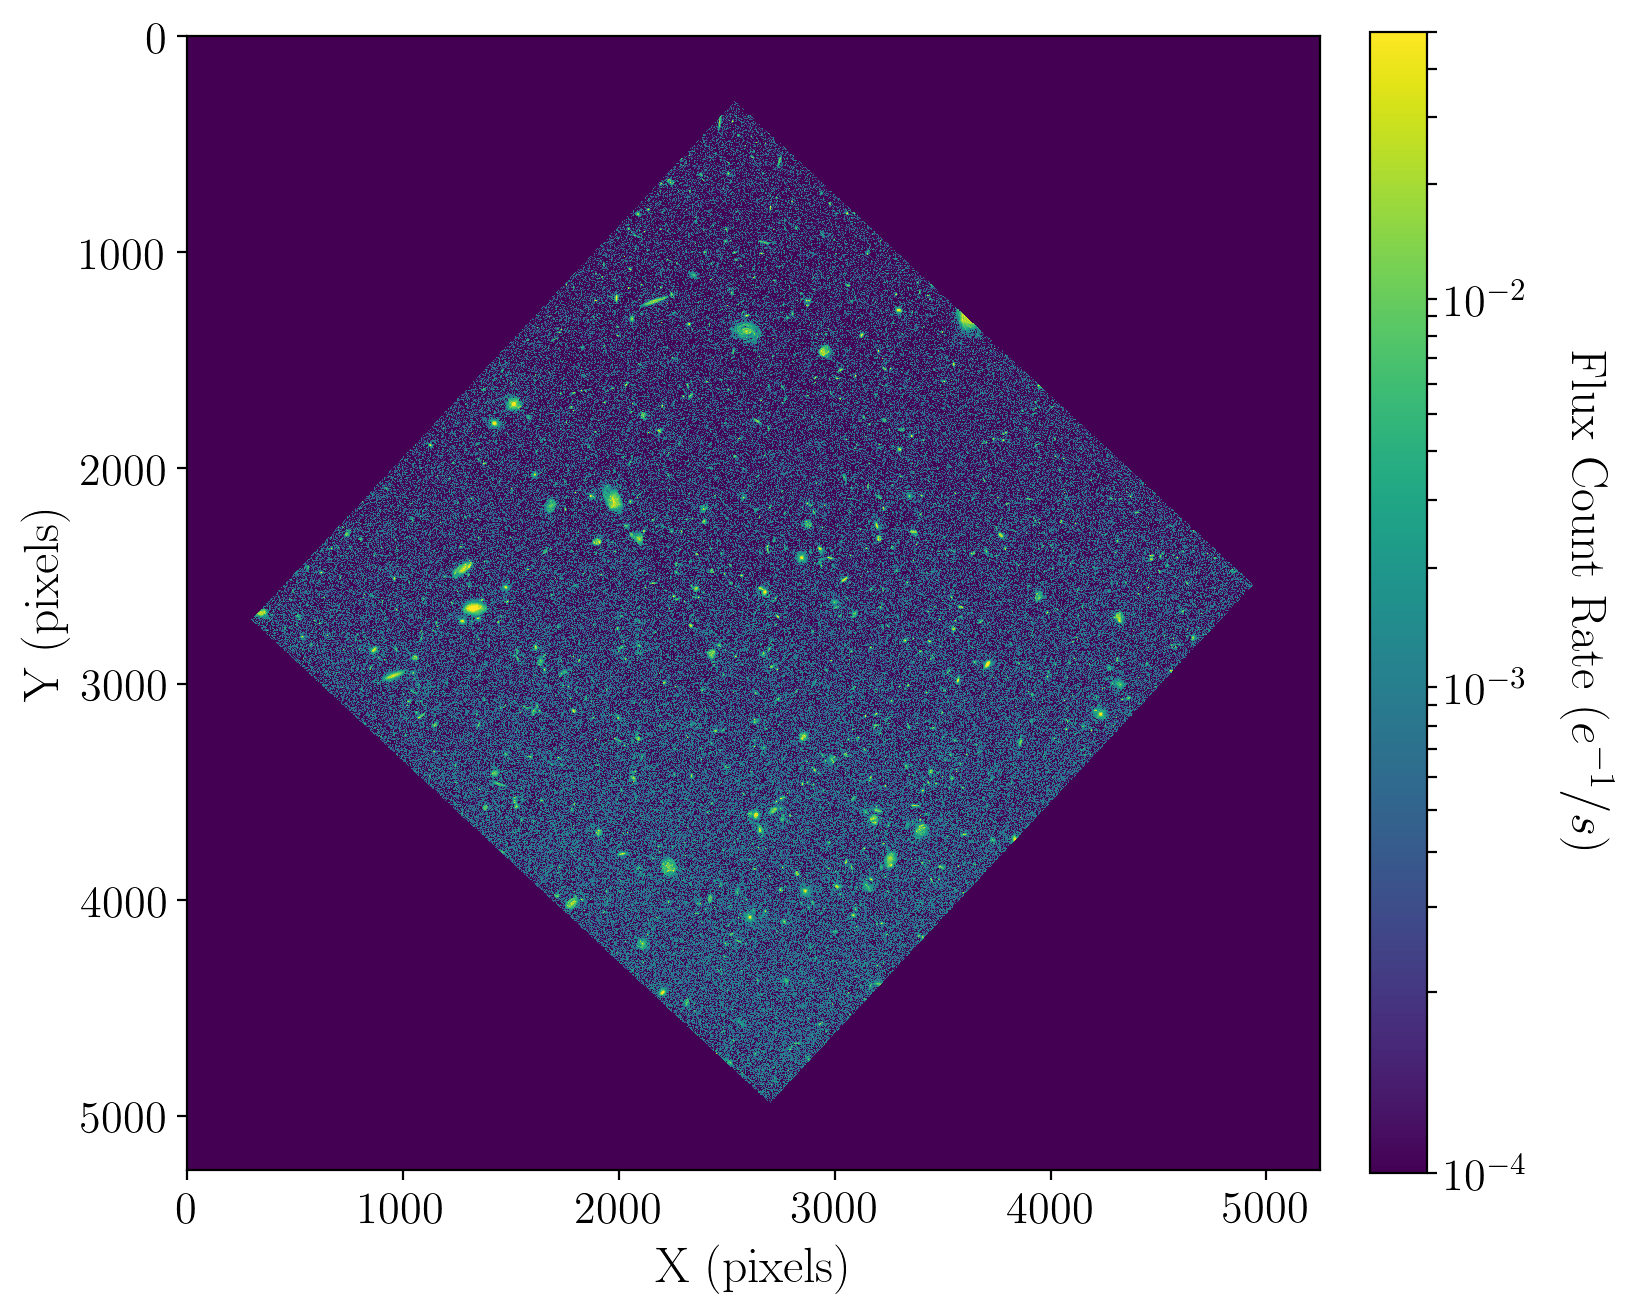

In [6]:
# Set up the figure with subplots
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# Plot the data
norm_image = ImageNormalize(vmin=1e-4, vmax=5e-2, stretch=LogStretch())
xdf_image_clipped = np.clip(xdf_image, 1e-4, None) # clip to plot with logarithmic stretch
fitsplot = ax1.imshow(xdf_image_clipped, norm=norm_image)

# Define the colorbar and fix the labels
cbar = plt.colorbar(fitsplot, fraction=0.046, pad=0.04, ticks=LogLocator(subs=range(10)))
labels = ['$10^{-4}$'] + [''] * 8 + ['$10^{-3}$'] + [''] * 8 + ['$10^{-2}$']
cbar.ax.set_yticklabels(labels)

# Define labels
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')

plt.show()

## Mask data

You probably noticed that a large portion of the data is equal to zero. The data we are using is a reduced mosaic that combines many different exposures, and that has been rotated such that not all of the array holds data. 

We want to **mask** out the non-data, so all of those pixels that have a value of zero don't interfere with our statistics and analyses of the data.

In [7]:
# Define the mask
xdf_image.mask = xdf_image.data == 0

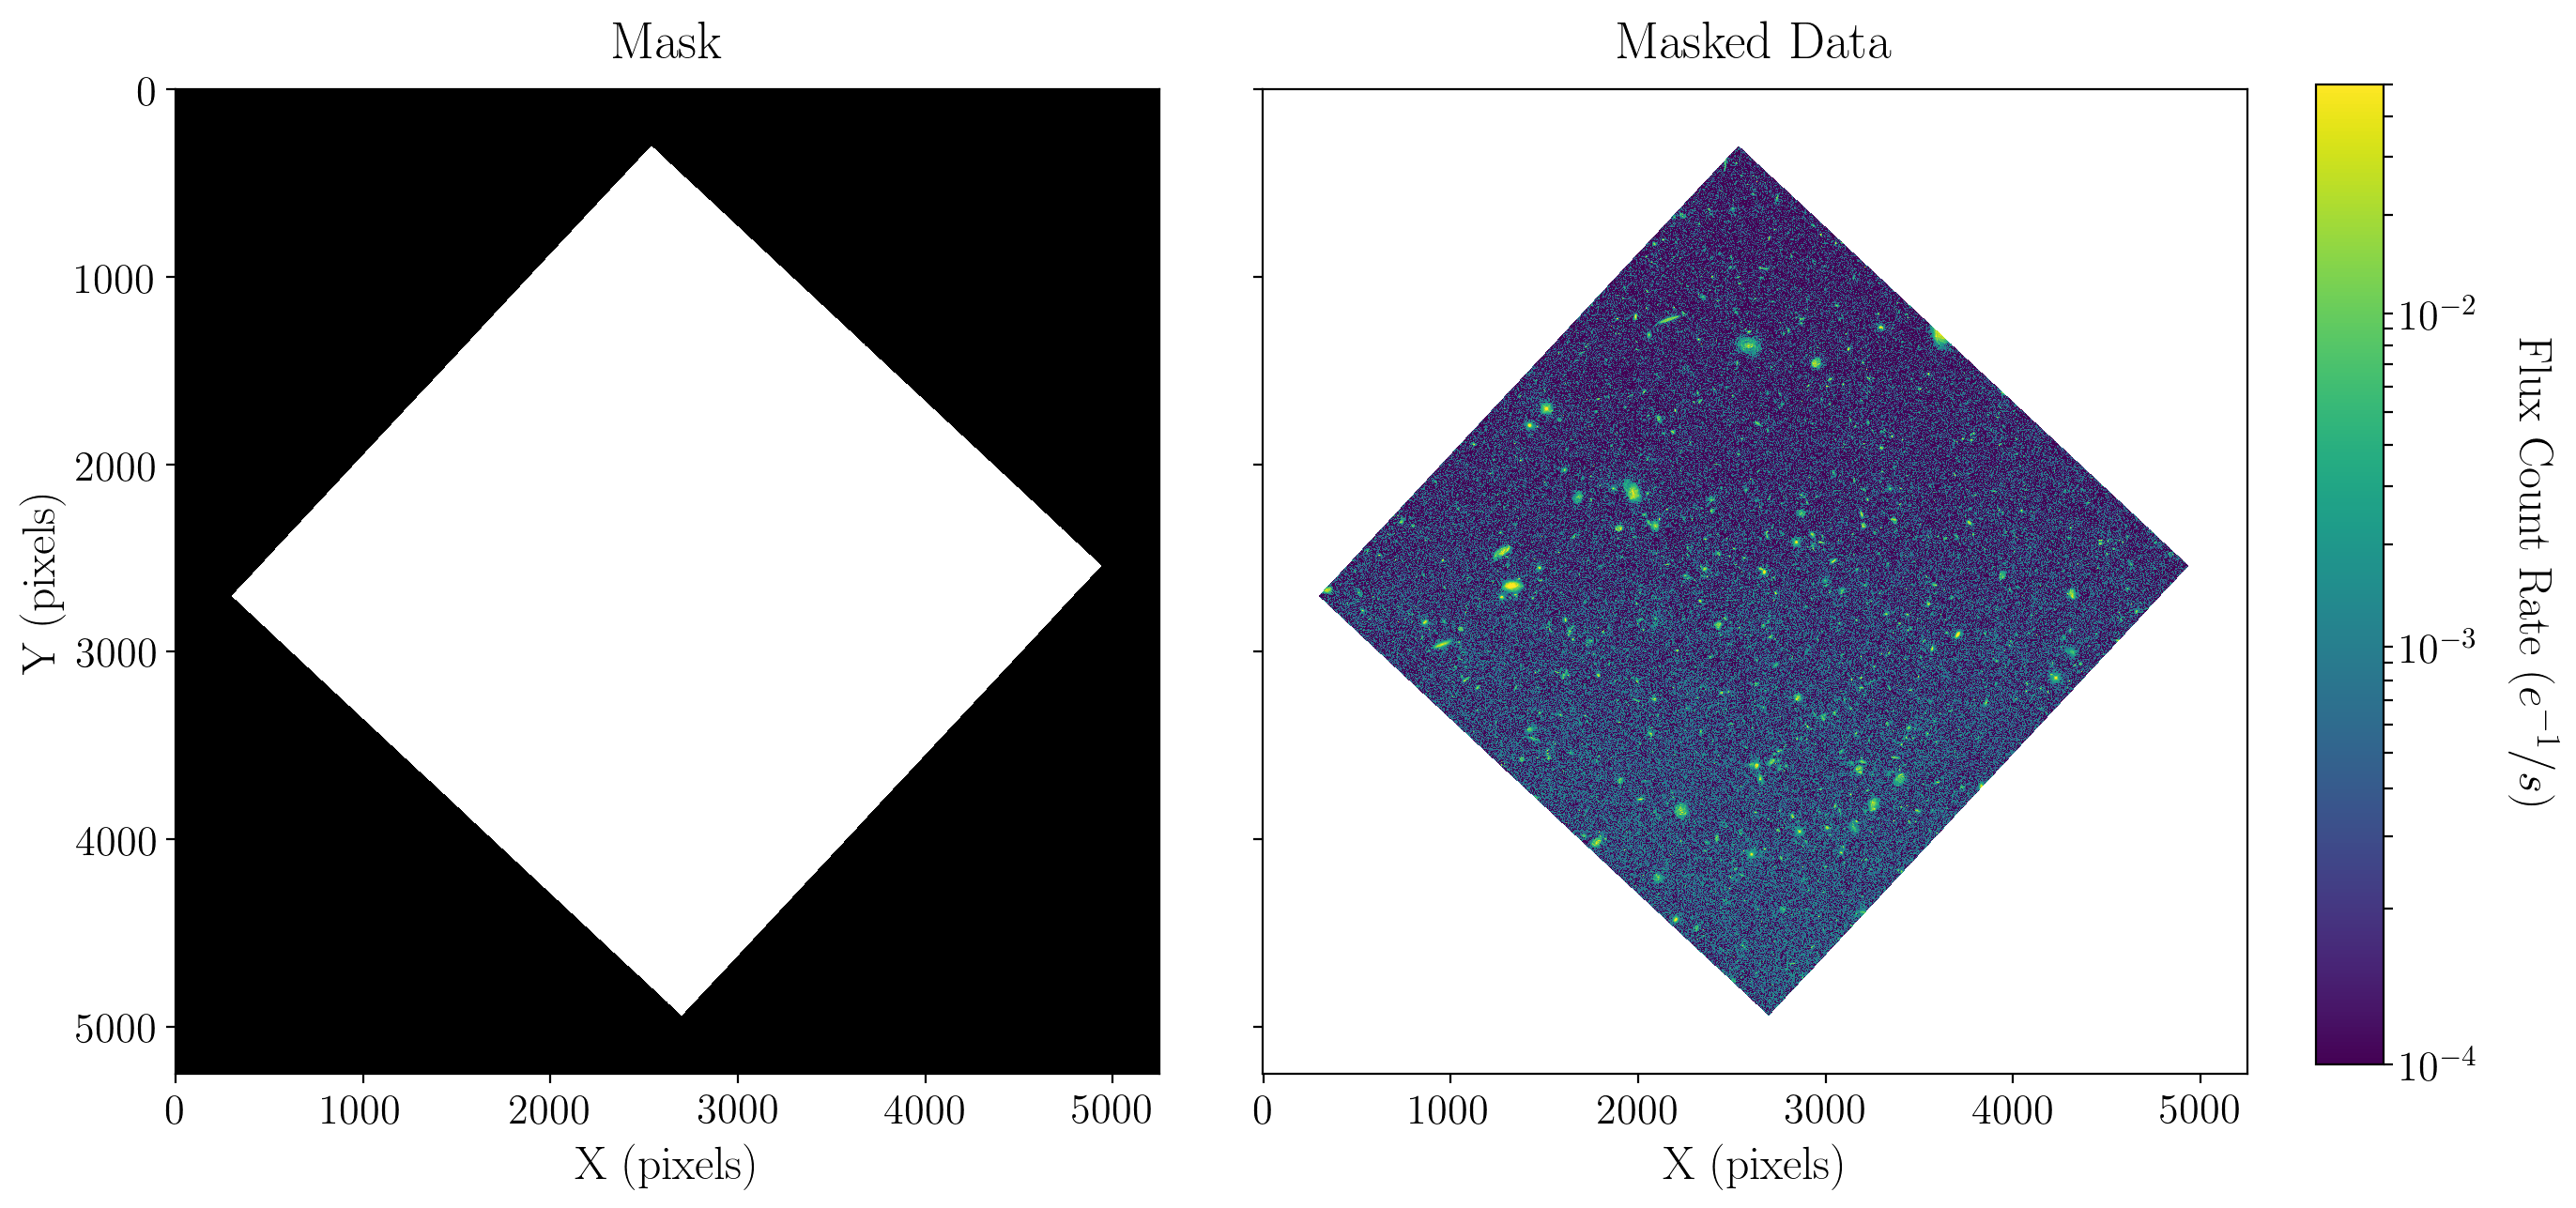

In [8]:
# Set up the figure with subplots
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plt.tight_layout()

# Plot the mask
ax1.imshow(xdf_image.mask, cmap='Greys')
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.set_title('Mask')

# Plot the masked data
norm_image = ImageNormalize(vmin=1e-4, vmax=5e-2, stretch=LogStretch())
fitsplot = ax2.imshow(np.ma.masked_where(xdf_image.mask, xdf_image_clipped), norm=norm_image)

# Define the colorbar and fix the labels
cbar_ax = fig.add_axes([1, 0.09, 0.03, 0.87])
cbar = fig.colorbar(fitsplot, cbar_ax, ticks=LogLocator(subs=range(10)))
labels = ['$10^{-4}$'] + [''] * 8 + ['$10^{-3}$'] + [''] * 8 + ['$10^{-2}$']
cbar.ax.set_yticklabels(labels)
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)
ax2.set_xlabel('X (pixels)')
ax2.set_title('Masked Data')

plt.show()

## Perform scalar background estimation

Now that the data are properly masked, we can calculate some basic statistical values to do a scalar estimation of the image background.

Here we will calculate the mean, median, and mode using sigma clipping. With sigma clipping, the data is iteratively clipped to exclude data points outside of a certain sigma (standard deviation), thus removing some of the noise from the data before determining statistical values.

In [11]:
mean, median, std = sigma_clipped_stats(xdf_image.data, sigma=3.0, iters=5, mask=xdf_image.mask)

But what difference does this sigma clipping make? And how important is masking, anyway? Let's visualize these statistics to get an idea:

In [13]:
# Calculate the data without masking
stats_nomask = sigma_clipped_stats(xdf_image.data, sigma=3.0, iters=5)

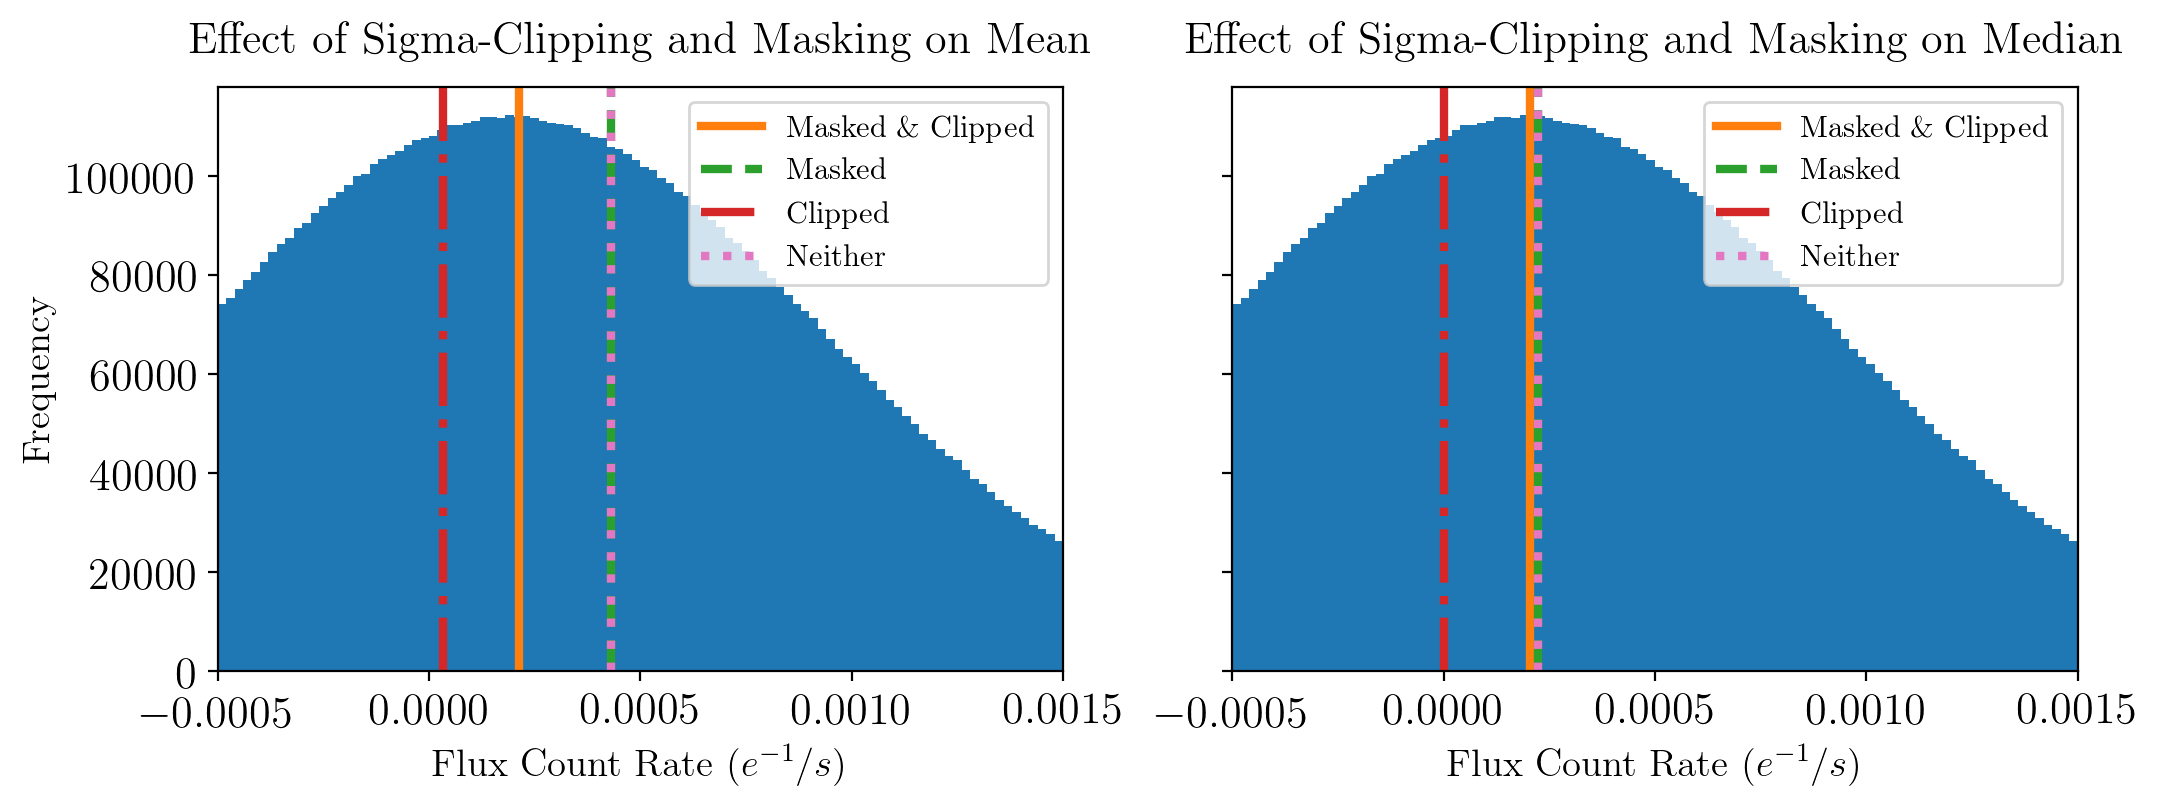

In [14]:
# Set up the figure with subplots
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Plot histograms of the data
flux_range = (-.5e-3, 1.5e-3)
ax1.hist(xdf_image[~xdf_image.mask], bins=100, range=flux_range)
ax2.hist(xdf_image[~xdf_image.mask], bins=100, range=flux_range)

# Plot lines for each kind of mean
ax1.axvline(mean, label='Masked \& Clipped', c='C1', lw=3)
ax1.axvline(np.average(xdf_image[~xdf_image.mask]), label='Masked', c='C2', ls='--', lw=3)
ax1.axvline(stats_nomask[0], label='Clipped', c='C3', ls='-.', lw=3)
ax1.axvline(np.average(xdf_image), label='Neither', c='C6', ls=':', lw=3)

ax1.set_xlim(flux_range)
ax1.set_xlabel(r'Flux Count Rate ($e^{-1}/s$)', fontsize=14)
ax1.set_ylabel('Frequency', fontsize=14)
ax1.set_title('Effect of Sigma-Clipping and Masking on Mean', fontsize=16)
ax1.legend(fontsize=11)


# Plot lines for each kind of median
# Note: use np.ma.median rather than np.median for masked arrays
ax2.axvline(median, label='Masked \& Clipped', c='C1', lw=3)
ax2.axvline(np.ma.median(xdf_image[~xdf_image.mask]), label='Masked', c='C2', ls='--', lw=3)
ax2.axvline(stats_nomask[1], label='Clipped', c='C3', ls='-.', lw=3)
ax2.axvline(np.ma.median(xdf_image), label='Neither', c='C6', ls=':', lw=3)

ax2.set_xlim(flux_range)
ax2.set_xlabel(r'Flux Count Rate ($e^{-1}/s$)', fontsize=14)
ax2.set_title('Effect of Sigma-Clipping and Masking on Median', fontsize=16)
ax2.legend(fontsize=11)

plt.show()

Just from simply looking at the distribution of the data, it is pretty easy to see how sigma-clipping and masking improve the calculation of the mean and median.

But enough looking at numbers, let's actually remove the background from the data - being careful to maintain the metadata and additional aspects of our original CCDData object.

In [15]:
# Copy the original image to maintain metadata, unit, and mask
xdf_scalar_bkgdsub = xdf_image.copy()

# Redefine the data attribute to be the scalar background subtraction
xdf_scalar_bkgdsub.data = xdf_image - mean

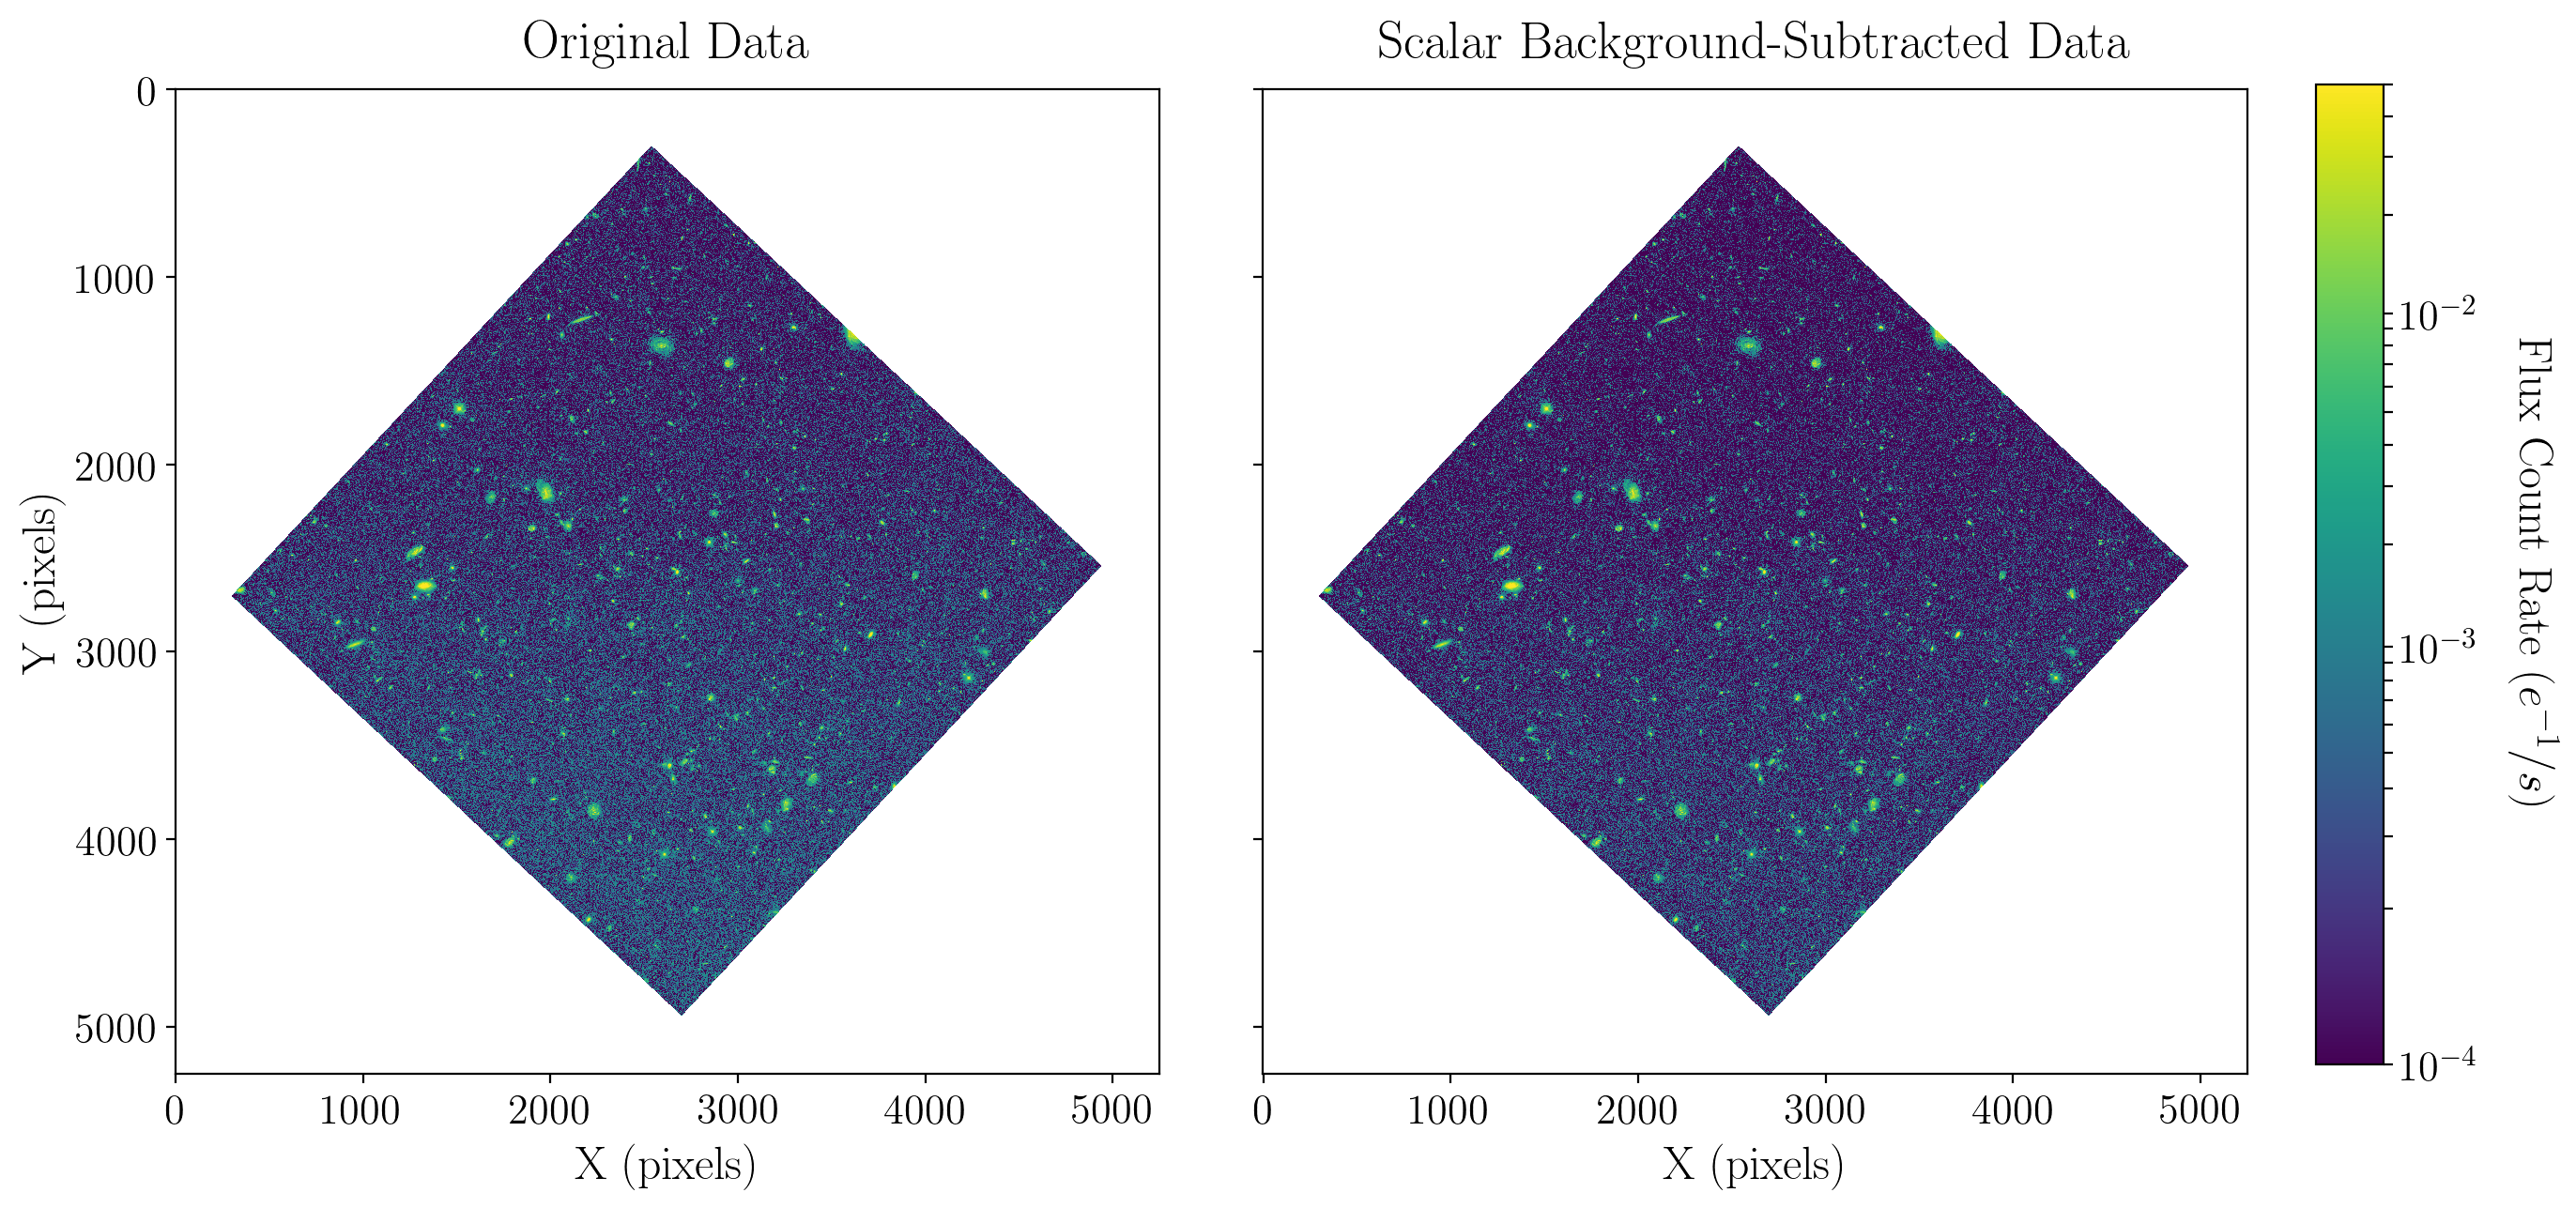

In [16]:
# Set up the figure with subplots
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plt.tight_layout()

# Define the normalization
norm_image = ImageNormalize(vmin=1e-4, vmax=5e-2, stretch=LogStretch())
xdf_scalar_bkgdsub_clipped = np.clip(xdf_scalar_bkgdsub, 1e-4, None) # clip to plot with logarithmic stretch

# Plot the original data
fitsplot = ax1.imshow(np.ma.masked_where(xdf_image.mask, xdf_image_clipped), norm=norm_image)
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.set_title('Original Data')

# Plot the subtracted data
fitsplot = ax2.imshow(np.ma.masked_where(xdf_scalar_bkgdsub.mask, xdf_scalar_bkgdsub_clipped), norm=norm_image)
ax2.set_xlabel('X (pixels)')
ax2.set_title('Scalar Background-Subtracted Data')

# Define the colorbar and fix the labels
cbar_ax = fig.add_axes([1, 0.09, 0.03, 0.87])
cbar = fig.colorbar(fitsplot, cbar_ax, ticks=LogLocator(subs=range(10)))
labels = ['$10^{-4}$'] + [''] * 8 + ['$10^{-3}$'] + [''] * 8 + ['$10^{-2}$']
cbar.ax.set_yticklabels(labels)
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)

plt.show()

That looks better! You can tell that the background is darker, especially in the top corner. However, the background still does not seem to be completely removed. In this case, the background varies spatially; it is 2-dimensional. Thankfully, `photutils` includes functions to remove background like this.

<div class="alert alert-block alert-info">
<h3>**Exercises:**</h3><br>
Perform a median scalar background subtraction on our sigma-clipped data. Plot it and visually inspect it. How does it compare to the original data?
<br><br>
Compare the median background subtraction to the mean background subtraction. Which is better?
</div>

## Perform 2-D background estimation

The `Background2D` class allows users to model 2-dimensional backgrounds, by evaluating the background signal in small boxes, and smoothing these boxes to reconstruct a continuous 2D background. The class includes the following arguments/attributes:
* **`box_size`** - the size of the boxes used to calculate the background. This should be larger than individual sources, yet still small enough to encompass changes in the background.
* **`filter_size`** - the size of the median filter used to smooth the final 2D background.
* **`filter_threshold`** - threshold below which the smoothing median filter will not be applied.
* **`sigma_clip`** - an ` astropy.stats.SigmaClip` object that is used to specify the sigma and number of iterations used to sigma-clip the data before background calculations are performed.
* **`bkg_estimator`** - the method used to perform the background calculation in each box (mean, median, SExtractor algorithm, etc.).

For this example, we will use the `MeanBackground` estimator.

In [17]:
from photutils.background import Background2D, MeanBackground

In [18]:
sigma_clip = SigmaClip(sigma=3., iters=5)
bkg_estimator = MeanBackground()
bkg = Background2D(xdf_image, box_size=200, filter_size=(10, 10), mask=xdf_image.mask,
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

So, what does this 2D background look like? Where were the boxes placed?

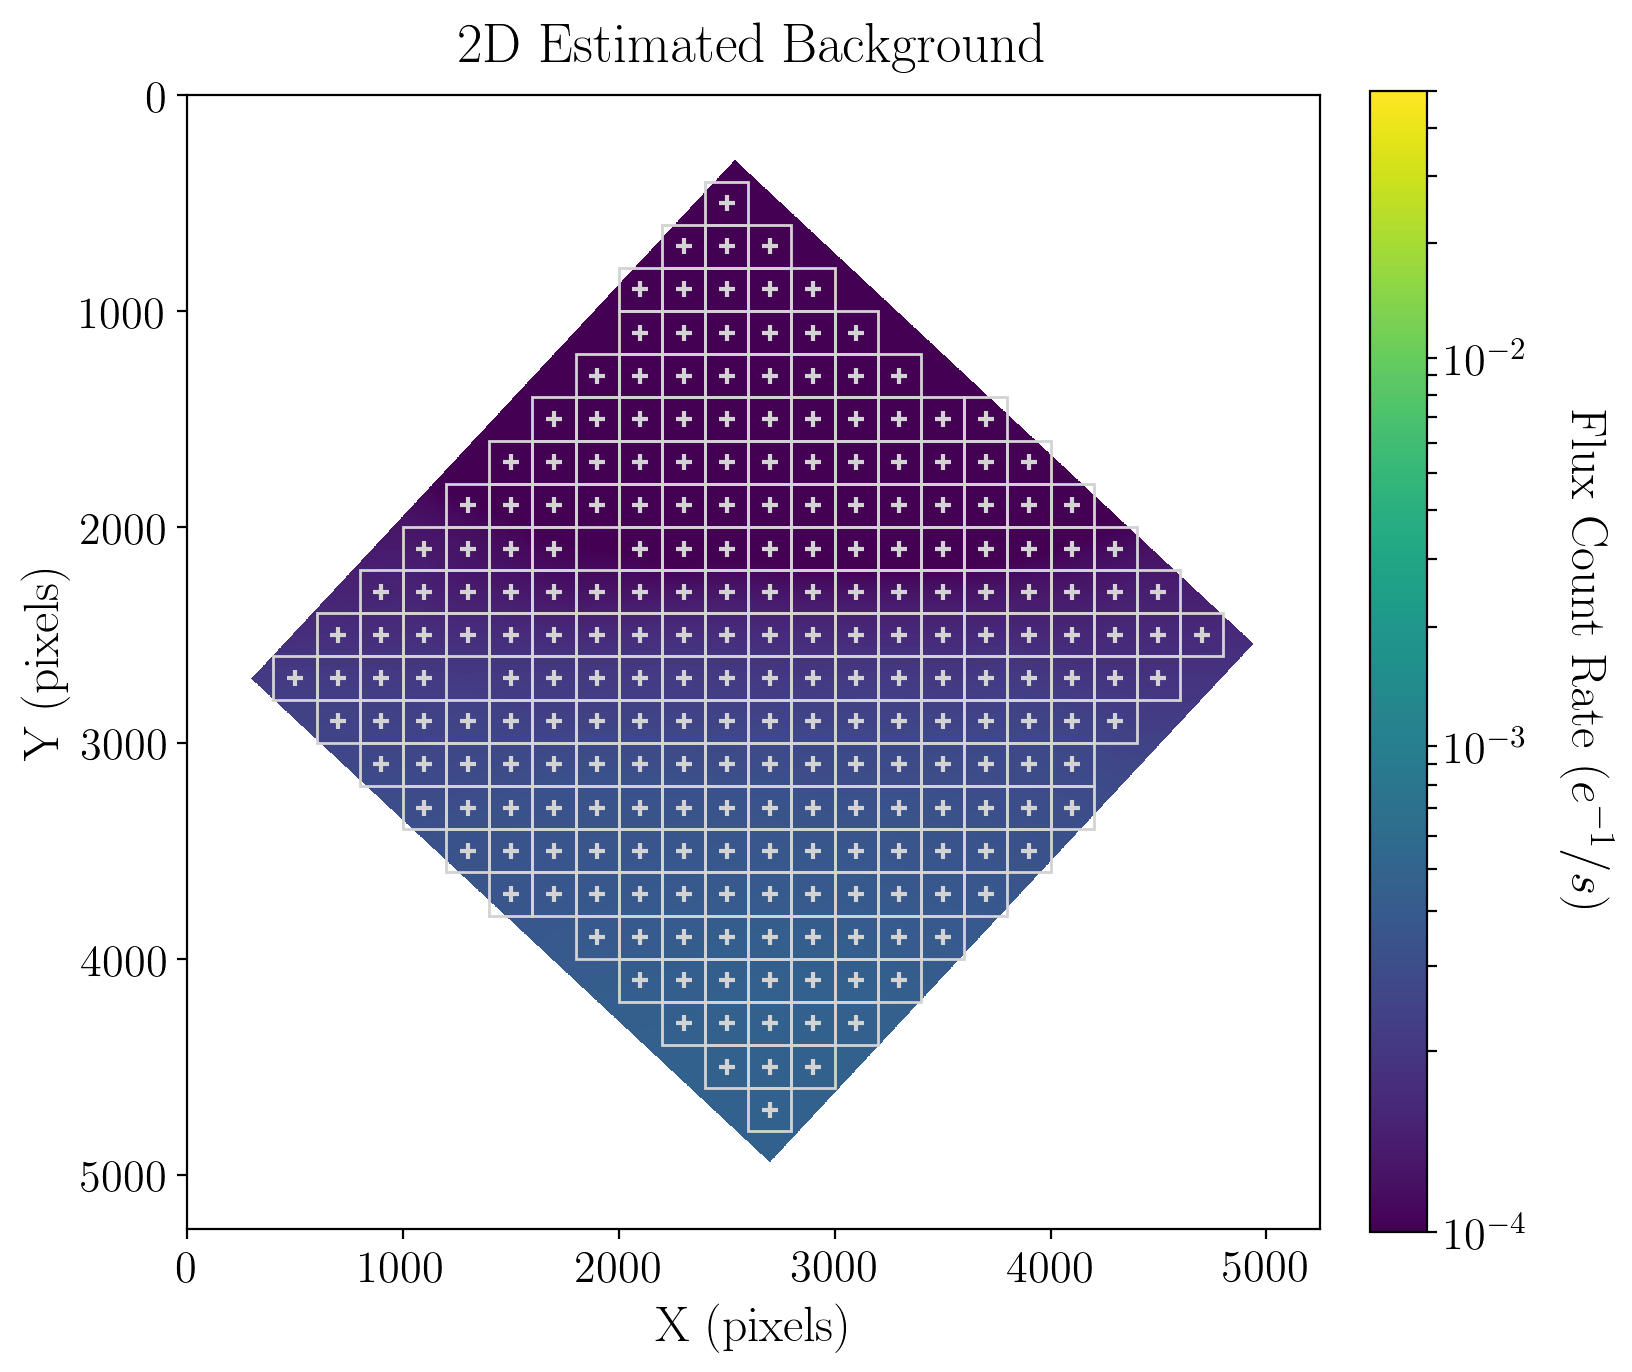

In [19]:
# Set up the figure with subplots
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# Plot the data
norm_image = ImageNormalize(vmin=1e-4, vmax=5e-2, stretch=LogStretch())
background_clipped = np.clip(bkg.background, 1e-4, None) # clip to plot with logarithmic stretch
fitsplot = ax1.imshow(np.ma.masked_where(xdf_image.mask, background_clipped), norm=norm_image)

# Plot the meshes
bkg.plot_meshes(outlines=True, color='lightgrey')

# Define the colorbar
cbar = plt.colorbar(fitsplot, fraction=0.046, pad=0.04, ticks=LogLocator(subs=range(10)))
labels = ['$10^{-4}$'] + [''] * 8 + ['$10^{-3}$'] + [''] * 8 + ['$10^{-2}$']
cbar.ax.set_yticklabels(labels)

# Define labels
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.set_title('2D Estimated Background')

plt.show()

And how does the data look if we use this background subtraction method (again maintaining the attributes of the CCDData object)?

In [20]:
# Copy the original image to maintain metadata, unit, and mask
xdf_2d_bkgdsub = xdf_image.copy()

# Redefine the data attribute to be the scalar background subtraction
xdf_2d_bkgdsub.data = xdf_image - bkg.background

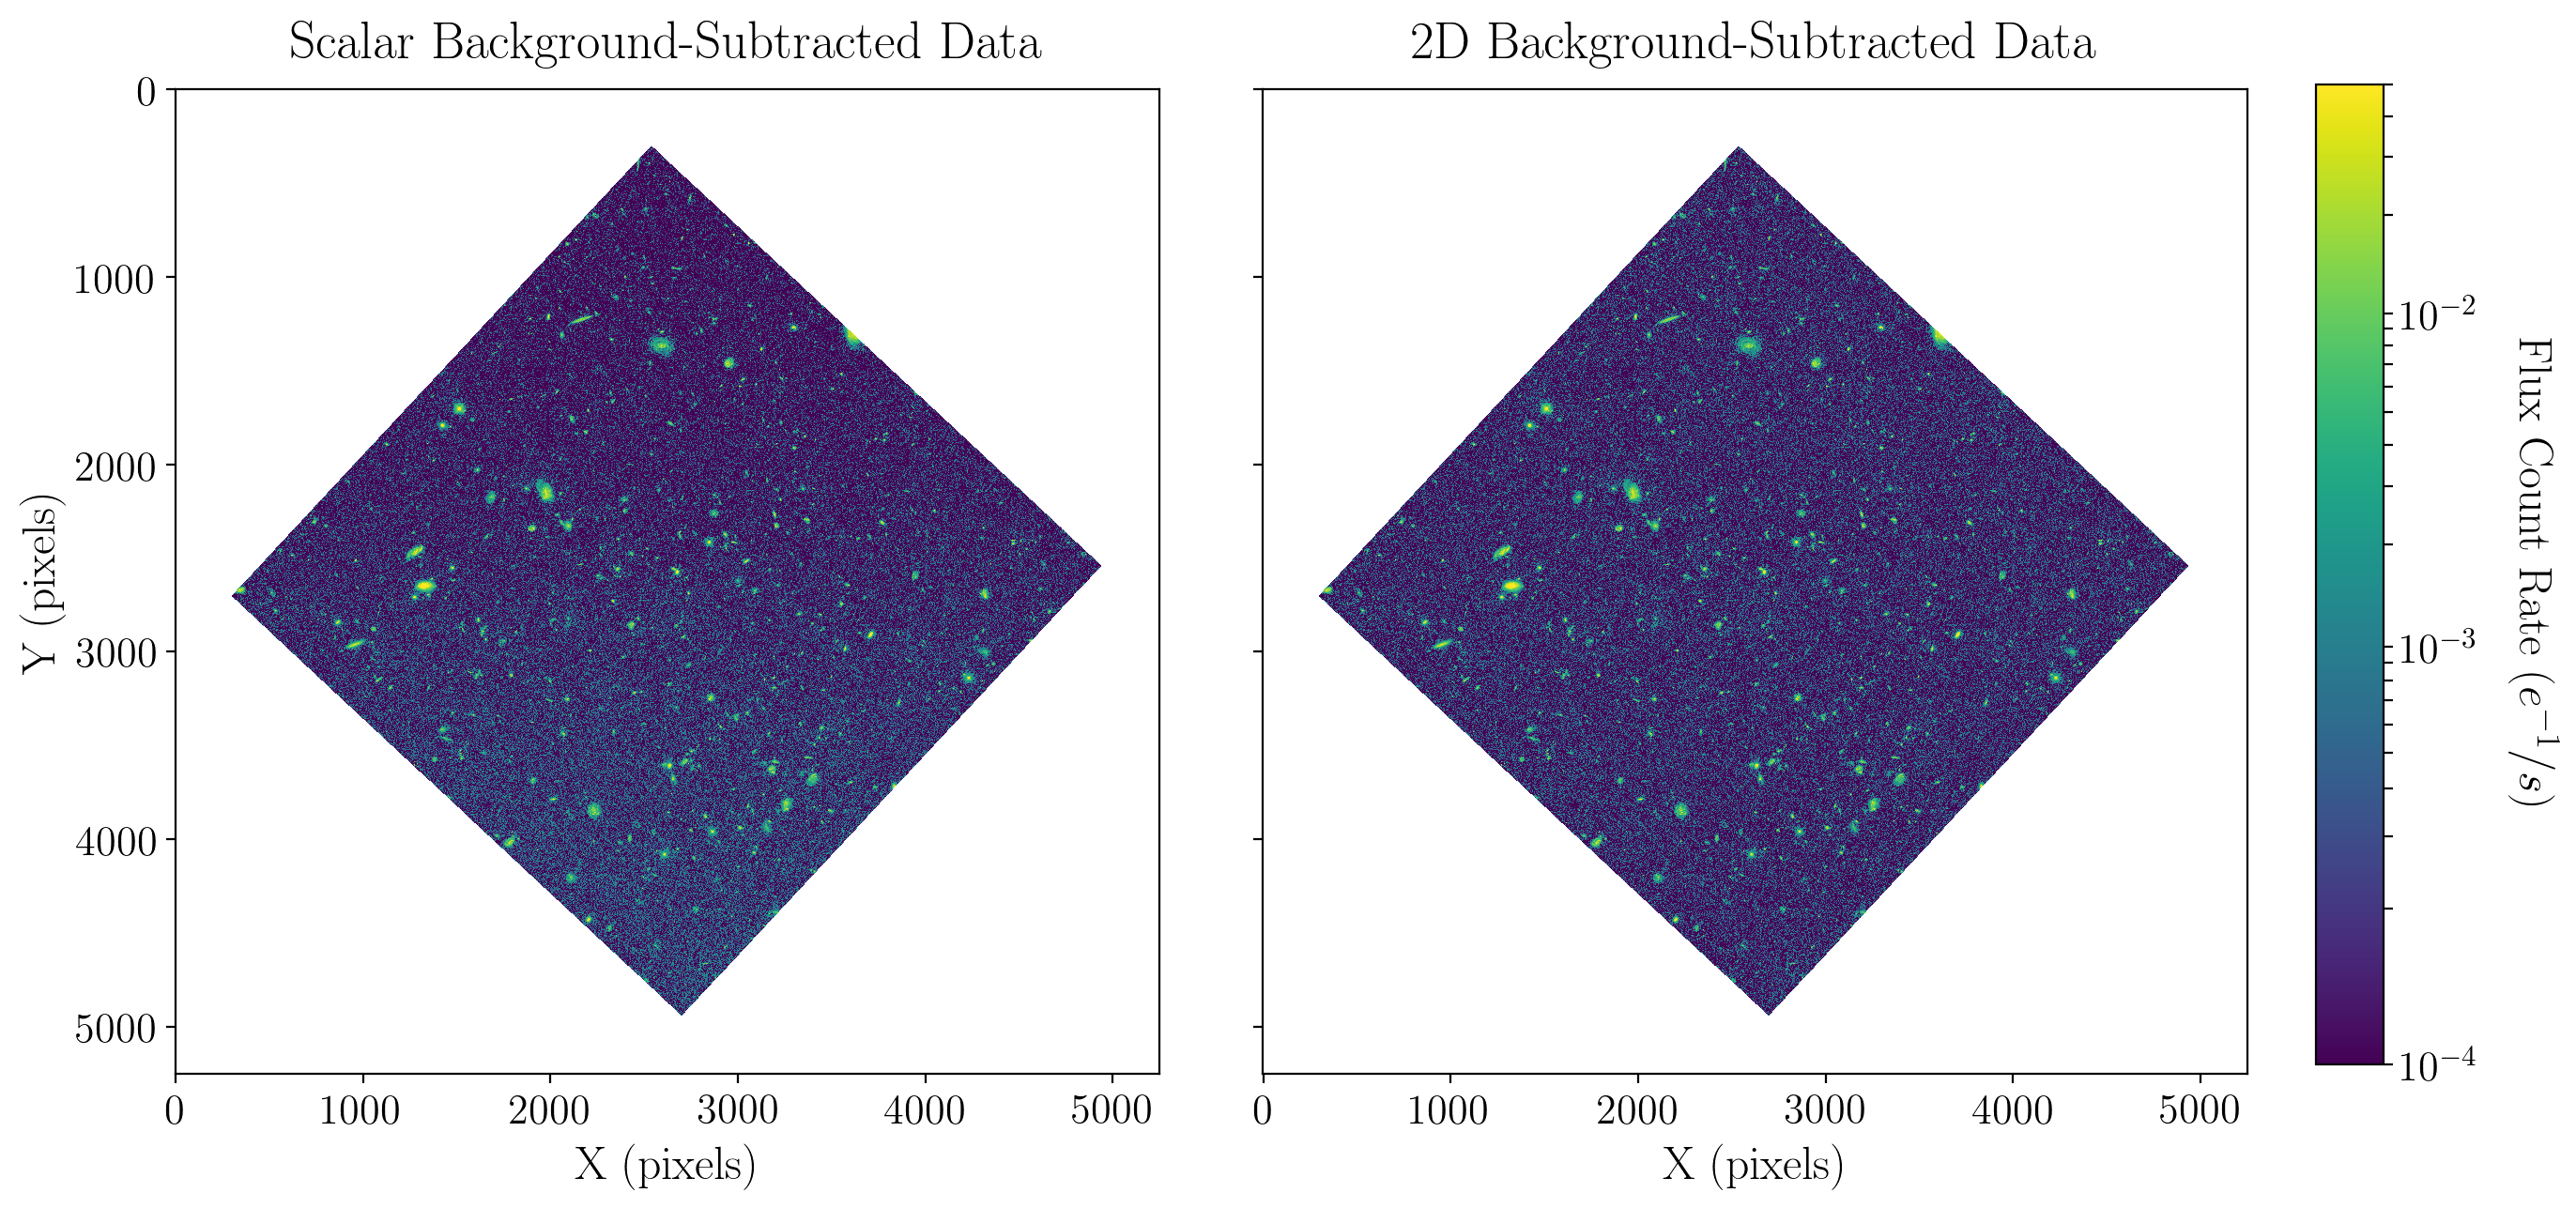

In [23]:
# Set up the figure with subplots
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plt.tight_layout()

# Define the normalization
norm_image = ImageNormalize(vmin=1e-4, vmax=5e-2, stretch=LogStretch())
xdf_2d_bkgdsub_clipped = np.clip(xdf_2d_bkgdsub, 1e-4, None) # clip to plot with logarithmic stretch

# Plot the scalar-subtracted data
fitsplot = ax1.imshow(np.ma.masked_where(xdf_scalar_bkgdsub.mask, xdf_scalar_bkgdsub_clipped), norm=norm_image)
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)
ax1.set_ylabel('Y (pixels)')
ax1.set_xlabel('X (pixels)')
ax1.set_title('Scalar Background-Subtracted Data')

# Plot the 2D-subtracted data
fitsplot = ax2.imshow(np.ma.masked_where(xdf_2d_bkgdsub.mask, xdf_2d_bkgdsub_clipped), norm=norm_image)
ax2.set_xlabel('X (pixels)')
ax2.set_title('2D Background-Subtracted Data')

# Plot the colorbar
cbar_ax = fig.add_axes([1, 0.09, 0.03, 0.87])
cbar = fig.colorbar(fitsplot, cbar_ax, ticks=LogLocator(subs=range(10)))
labels = ['$10^{-4}$'] + [''] * 8 + ['$10^{-3}$'] + [''] * 8 + ['$10^{-2}$']
cbar.ax.set_yticklabels(labels)
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)

plt.show()

Note how much more even the 2D background-subtracted image looks; especially the difference between these two images in the bottom corner and top corner. This makes sense, as the background that `Background2D` identified was a gradient from the top corner down to the bottom!

<div class="alert alert-block alert-info">
<h3>**Exercises:**</h3><br>
Perform a 2D background subtraction using the `MedianBackground` estimator. <br><br>
Compare the scalar background subtraction to the 2D background subtraction. Which is better?
</div>

## Conclusions

The `photutils` package provides a powerful tool in the `Background2D` class, allowing users to easily estimate and subtract spatially variant background signals from their data.

##### To continue with this `photutils` tutorial, go on to the [source detection notebook](02_photutils_source_detection.ipynb).

---
<i>June 2018

Author: Lauren Chambers (lchambers@stsci.edu)

For more examples and details, please visit the [photutils](http://photutils.readthedocs.io/en/stable/index.html) documentation.</i>